In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from numpy import shape
import csv
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import pickle

# My imports
import generative_models.load as load

In [25]:
# Load dataset
# Load dataset
#filename_wind = 'generative_models/data/less_windy.csv'
#trX, trY, X_test, Y_test = load.load_wind(filename_wind, sample_size=2)

# filename_solar = 'generative_models/data/solar.csv'
# trX, X_test = load.load_solar(filename_solar, sample_size=2)

# # Load solar dataset from 2006
# filename_solar_2006 = 'generative_models/data/solar_2006.csv'
# file_labels = 'generative_models/data/solar label.csv'
# trX, X_test, trY, y_test = load.load_solar_2006(filename_solar_2006, file_labels, testsize=0.2, sample_size=2)
# max_output = 74
# num_categories = 12
# trX, X_test = trX / max_output, X_test / max_output

# Files to load load data
filename_daily_samples_load = 'generative_models/data/load_2017_2days.csv'
filename_labels_per_month = 'generative_models/data/load_labels_monthly.csv'
filename_labels_per_loc = 'generative_models/data/load_labels_loc.csv' 
# Load data with labels indicating month
#trX, X_test, trY, y_test = load.load_load(filename_daily_samples_load, filename_labels_per_month, testsize=0.01)
# Load data with labels indicating month
trX, X_test, trY, y_test = load.load_load(filename_daily_samples_load, filename_labels_per_loc, testsize=0.01)
num_categories = np.max(trY) + 1
max_output = 1

print("Shape of training samples ", shape(trX))
print("Training data loaded")
print("Number of categories: ", num_categories)

Solar data loaded
Total number of samples: 730
Shape of training dataset: (722, 576)
Shape of test datasaet: (8, 576)
Shape of training samples  (722, 576)
Training data loaded
Number of categories:  5


In [11]:
# Statistics about training data
# mean_per_category = []
# for i in range(num_categories):
#     subset = trX[trY.flatten() == i]
#     mean_per_category.append(np.mean(subset) * max_output)
# plt.plot(mean_per_category, marker='*')
# plt.title('Mean of solar production per month for 74MW installed')
# plt.xlabel('Month (Jan - Dec)')
# plt.ylabel('Average generation (MW)')
# plt.savefig('../VER_GenerativeModelling_RLAllocation/generative_models/figures/solar_mean_per_month.png')

In [26]:
# Create OneHot encoder to encode labels
enc = OneHotEncoder(sparse=False)
enc.fit(trY)

/anaconda3/envs/cs159/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:414: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=False)

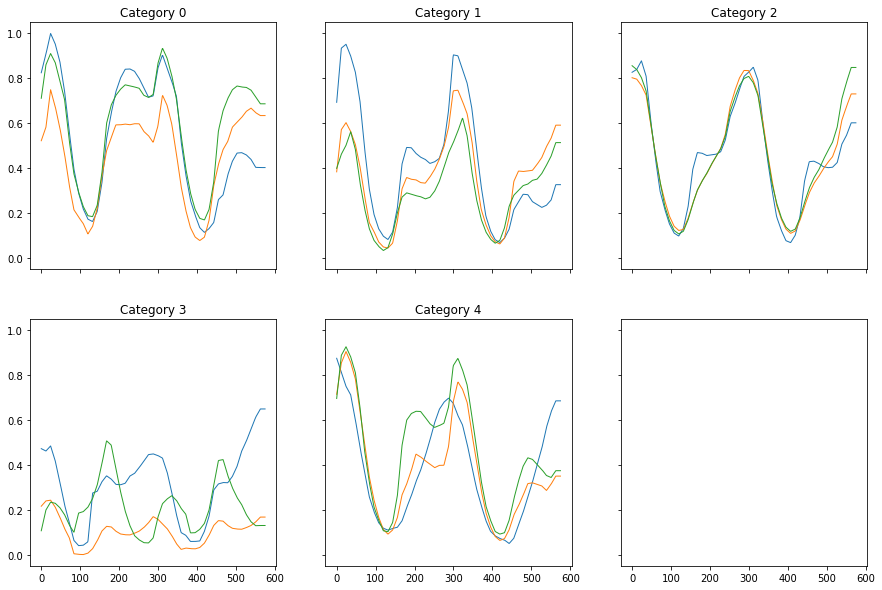

In [27]:
# Plot examples of each category
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15, 10))
axes = axes.flatten()

for i in range(num_categories):
    index = (trY == i).flatten()
    subset = trX[index]
    example = subset[np.random.randint(subset.shape[0], size=3)]
    example = example * max_output

    ax = axes[i]
    for e in example:
        ax.plot(e, linewidth=1.)
    ax.title.set_text(f'Category {i}')
    

# plt.savefig('../VER_GenerativeModelling_RLAllocation/generative_models/figures'
#             '/solar_categories_examples.png',
#             tight_layout=True)
plt.show()

In [28]:
### model.py file ###

#The GANs model with Wasserstein distance along with helper functions

def batchnormalize(X, eps=1e-8, g=None, b=None):
    if X.get_shape().ndims == 4:
        mean = tf.reduce_mean(X, [0,1,2])
        std = tf.reduce_mean( tf.square(X-mean), [0,1,2] )
        X = (X-mean) / tf.sqrt(std+eps)

        if g is not None and b is not None:
            g = tf.reshape(g, [1,1,1,-1])
            b = tf.reshape(b, [1,1,1,-1])
            X = X*g + b

    elif X.get_shape().ndims == 2:
        mean = tf.reduce_mean(X, 0)
        std = tf.reduce_mean(tf.square(X-mean), 0)
        X = (X-mean) / tf.sqrt(std+eps)

        if g is not None and b is not None:
            g = tf.reshape(g, [1,-1])
            b = tf.reshape(b, [1,-1])
            X = X*g + b

    else:
        raise NotImplementedError

    return X

def lrelu(X, leak=0.2):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * X + f2 * tf.abs(X)

# def bce(o, t):
#     o = tf.clip_by_value(o, 1e-7, 1. - 1e-7)
#     return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(o, t))


# model in DCGAN:
# discriminate, generate, samples_generator
class GAN():
    def __init__(
            self,
            batch_size=32,
            image_shape=[24,24,1],
            dim_z=100,
            dim_W1=1024,
            dim_W2=128,
            dim_W3=64,
            dim_channel=1,
            dim_y = 5,
            max_value = 16
            ):

        self.batch_size = batch_size
        self.image_shape = image_shape
        self.dim_z = dim_z
        self.max_value = max_value
        self.dim_y = dim_y

        self.dim_W1 = dim_W1
        self.dim_W2 = dim_W2
        self.dim_W3 = dim_W3
        self.dim_channel = dim_channel
        self.gen_W1 = tf.Variable(tf.random_normal([dim_z + dim_y, dim_W1], stddev=0.02), name='gen_W1')
        self.gen_W2 = tf.Variable(tf.random_normal([dim_W1 + dim_y, dim_W2*6*6], stddev=0.02), name='gen_W2')
        self.gen_W3 = tf.Variable(tf.random_normal([5, 5, dim_W3, dim_W2 + dim_y], stddev=0.02), name='gen_W3')
        self.gen_W4 = tf.Variable(tf.random_normal([5, 5, dim_channel, dim_W3 + dim_y], stddev=0.02), name='gen_W4')

        self.discrim_W1 = tf.Variable(tf.random_normal([5, 5, dim_channel + dim_y, dim_W3], stddev=0.02), name='discrim_W1')
        self.discrim_W2 = tf.Variable(tf.random_normal([5, 5, dim_W3 + dim_y, dim_W2], stddev=0.02), name='discrim_W2')
        self.discrim_W3 = tf.Variable(tf.random_normal([dim_W2*6*6 + dim_y, dim_W1], stddev=0.02), name='discrim_W3')
        self.discrim_W4 = tf.Variable(tf.random_normal([dim_W1 + dim_y, 1], stddev=0.02), name='discrim_W4')

    def build_model(self):

        Z = tf.placeholder(tf.float32, [self.batch_size, self.dim_z], name='Z_placeholder')
        Y = tf.placeholder(tf.float32, [self.batch_size, self.dim_y], name='Y_placeholder')

        image_real = tf.placeholder(tf.float32, [self.batch_size] + self.image_shape, name='image_real_placeholder')
        h4 = self.generator(Z, Y)
        #image_gen comes from sigmoid output of generator
        image_gen = tf.nn.sigmoid(h4)

        raw_real2 = self.discriminate(image_real, Y)
        p_real=tf.reduce_mean(raw_real2)

        raw_gen2 = self.discriminate(image_gen, Y)
        p_gen = tf.reduce_mean(raw_gen2)

        discrim_cost = tf.reduce_sum(raw_real2) - tf.reduce_sum(raw_gen2)
        gen_cost = -tf.reduce_mean(raw_gen2)

        return Z, Y, image_real, discrim_cost, gen_cost, p_real, p_gen


    def discriminate(self, image, Y):
        print("Initializing the discriminator")
        
        yb = tf.reshape(Y, tf.stack([self.batch_size, 1, 1, self.dim_y]))
        X = tf.concat([image, yb * tf.ones([self.batch_size, 24, 24, self.dim_y])], 3)
        
        h1 = lrelu( tf.nn.conv2d(X, self.discrim_W1, strides=[1,2,2,1],
                                 padding='SAME' ))
        print("h1 shape", h1.get_shape())
        h1 = tf.concat([h1, yb * tf.ones([self.batch_size, 12, 12, self.dim_y])],3)

        h2 = lrelu(batchnormalize(tf.nn.conv2d(h1, self.discrim_W2, strides=[1,2,2,1], padding='SAME')) )
        print("h2 shape", h2.get_shape())

        h2 = tf.reshape(h2, [self.batch_size, -1])
        h2 = tf.concat([h2, Y], 1)
        discri = tf.matmul(h2, self.discrim_W3 )
        print("discri shape", discri.get_shape())

        h3 = lrelu(batchnormalize(discri))
        return h3


    def generator(self, Z, Y):
        print("Initializing the generator")
        print("Input Z shape", Z.get_shape())
        
        yb = tf.reshape(Y, [self.batch_size, 1, 1, self.dim_y])
        Z_new = tf.concat([Z, Y], 1)

        h1 = tf.nn.relu(batchnormalize(tf.matmul(Z_new, self.gen_W1)))
        print("h1 shape", h1.get_shape())
        h1 = tf.concat([h1, Y],1)

        h2 = tf.nn.relu(batchnormalize(tf.matmul(h1, self.gen_W2)))
        print("h2 shape", h2.get_shape())
        h2 = tf.reshape(h2, [self.batch_size,6,6,self.dim_W2])
        print("h2 shape", h2.get_shape())
        h2 = tf.concat([h2, yb * tf.ones([self.batch_size, 6, 6, self.dim_y])], 3)

        output_shape_l3 = [self.batch_size,12,12,self.dim_W3]
        h3 = tf.nn.conv2d_transpose(h2, self.gen_W3, output_shape=output_shape_l3, strides=[1,2,2,1])
        h3 = tf.nn.relu( batchnormalize(h3))
        print("h3 shape", h3.get_shape())
        h3 = tf.concat([h3, yb * tf.ones([self.batch_size, 12, 12, self.dim_y])], 3)

        output_shape_l4 = [self.batch_size,24,24,self.dim_channel]
        h4 = tf.nn.conv2d_transpose(h3, self.gen_W4, output_shape=output_shape_l4, strides=[1,2,2,1])
        return h4


    def samples_generator(self, batch_size):
        Z = tf.placeholder(tf.float32, [batch_size, self.dim_z], name='Z_samples_placeholder')
        Y = tf.placeholder(tf.float32, [batch_size, self.dim_y], name='Y_samples_placeholder')
        
        yb = tf.reshape(Y, [batch_size, 1, 1, self.dim_y])
        Z_new = tf.concat([Z,Y], 1)

        h1 = tf.nn.relu(batchnormalize(tf.matmul(Z_new, self.gen_W1)))
        h1 = tf.concat([h1, Y], 1)

        h2 = tf.nn.relu(batchnormalize(tf.matmul(h1, self.gen_W2)))
        h2 = tf.reshape(h2, [batch_size,6,6,self.dim_W2])
        h2 = tf.concat([h2, yb * tf.ones([batch_size, 6, 6, self.dim_y])], 3)

        output_shape_l3 = [batch_size,12,12,self.dim_W3]
        h3 = tf.nn.conv2d_transpose(h2, self.gen_W3, output_shape=output_shape_l3, strides=[1,2,2,1])
        h3 = tf.nn.relu(batchnormalize(h3))
        h3 = tf.concat([h3, yb * tf.ones([batch_size, 12, 12,self.dim_y])], 3)

        output_shape_l4 = [batch_size,24,24,self.dim_channel]
        h4 = tf.nn.conv2d_transpose(h3, self.gen_W4, output_shape=output_shape_l4, strides=[1,2,2,1])
        x = tf.nn.sigmoid(h4, name='image_samples_placeholder')
        return Z, Y, x

In [37]:
### Build model

# Parameters
batch_size = 32
image_shape = [24,24,1] # The shape for input data
dim_z = 100             # Input dimension for latent vector z
dim_W1 = 1024           # Units in first neuron layer
dim_W2 = 128            # Units in second neuron layer
dim_W3 = 64             # Units in third neuron layer
mu, sigma = 0, 0.1      # Parameters of input Gaussian
dim_y = num_categories
max_value = 1          # Maximum value in time series

visualize_dim = batch_size

# Initialize model
gan = GAN(batch_size=batch_size,
                  image_shape=image_shape,
                  dim_z=dim_z,
                  dim_W1=dim_W1,
                  dim_W2=dim_W2,
                  dim_W3=dim_W3,
                  dim_channel=1,
                  dim_y = dim_y,
                  max_value=max_value)
print("W_DCGAN model initialized\n")


#Z_tf,Y_tf: placeholder
#image_tf: image placeholder
#d_cost_tf, g_cost_tf: discriminator and generator cost
#p_real, p_gen: the output of discriminator to judge real/generated

Z_tf, Y_tf, image_tf, d_cost_tf, g_cost_tf, p_real, p_gen = gan.build_model()

W_DCGAN model initialized

Initializing the generator
Input Z shape (32, 100)
h1 shape (32, 1024)
h2 shape (32, 4608)
h2 shape (32, 6, 6, 128)
h3 shape (32, 12, 12, 64)
Initializing the discriminator
h1 shape (32, 12, 12, 64)
h2 shape (32, 6, 6, 128)
discri shape (32, 1024)
Initializing the discriminator
h1 shape (32, 12, 12, 64)
h2 shape (32, 6, 6, 128)
discri shape (32, 1024)


/anaconda3/envs/cs159/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Iterations: 0
iterations  0
Average P(real)= 0.33564895
Average P(gen)= 0.33608186
Discrim loss: -14.185547


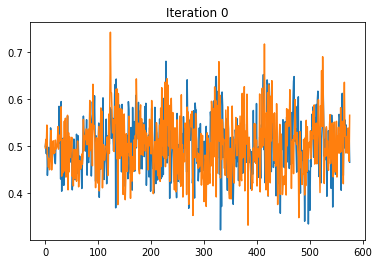

Iterations: 22
Iterations: 44
Iterations: 66
Iterations: 88
Iterations: 110
Iterations: 132
Iterations: 154
Iterations: 176
Iterations: 198
Iterations: 220
Iterations: 242
Iterations: 264
Iterations: 286
Iterations: 308
Iterations: 330
Iterations: 352
Iterations: 374
Iterations: 396
Iterations: 418
Iterations: 440
Iterations: 462
Iterations: 484
iterations  500
Average P(real)= 0.3839792
Average P(gen)= 0.2701733
Discrim loss: 3729.1914


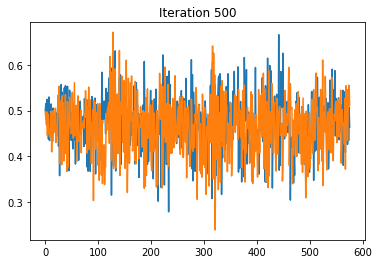

Iterations: 506
Iterations: 528
Iterations: 550
Iterations: 572
Iterations: 594
Iterations: 616
Iterations: 638
Iterations: 660
Iterations: 682
Iterations: 704
Iterations: 726
Iterations: 748
Iterations: 770
Iterations: 792
Iterations: 814
Iterations: 836
Iterations: 858
Iterations: 880
Iterations: 902
Iterations: 924
Iterations: 946
Iterations: 968
Iterations: 990
iterations  1000
Average P(real)= 0.37600273
Average P(gen)= 0.29571402
Discrim loss: 2630.9004


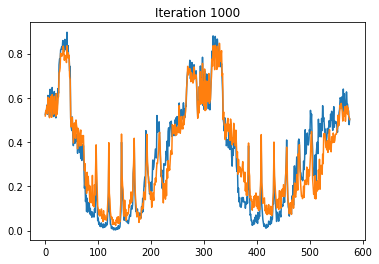

Iterations: 1012
Iterations: 1034
Iterations: 1056
Iterations: 1078
Iterations: 1100
Iterations: 1122
Iterations: 1144
Iterations: 1166
Iterations: 1188
Iterations: 1210
Iterations: 1232
Iterations: 1254
Iterations: 1276
Iterations: 1298
Iterations: 1320
Iterations: 1342
Iterations: 1364
Iterations: 1386
Iterations: 1408
Iterations: 1430
Iterations: 1452
Iterations: 1474
Iterations: 1496
iterations  1500
Average P(real)= 0.37251297
Average P(gen)= 0.30274108
Discrim loss: 2286.2852


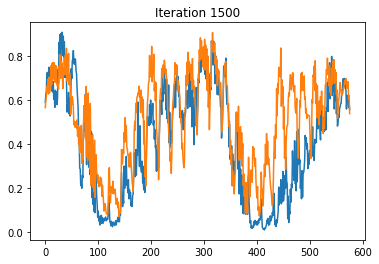

Iterations: 1518
Iterations: 1540
Iterations: 1562
Iterations: 1584
Iterations: 1606
Iterations: 1628
Iterations: 1650
Iterations: 1672
Iterations: 1694
Iterations: 1716
Iterations: 1738
Iterations: 1760
Iterations: 1782
Iterations: 1804
Iterations: 1826
Iterations: 1848
Iterations: 1870
Iterations: 1892
Iterations: 1914
Iterations: 1936
Iterations: 1958
Iterations: 1980
iterations  2000
Average P(real)= 0.38127398
Average P(gen)= 0.28751525
Discrim loss: 3072.2861


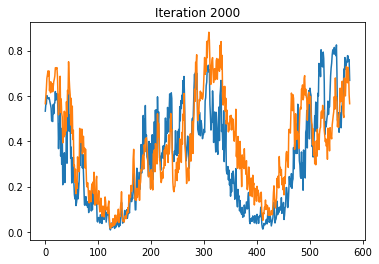

Iterations: 2002
Iterations: 2024
Iterations: 2046
Iterations: 2068
Iterations: 2090
Iterations: 2112
Iterations: 2134
Iterations: 2156
Iterations: 2178
Iterations: 2200
Iterations: 2222
Iterations: 2244
Iterations: 2266
Iterations: 2288
Iterations: 2310
Iterations: 2332
Iterations: 2354
Iterations: 2376
Iterations: 2398
Iterations: 2420
Iterations: 2442
Iterations: 2464
Iterations: 2486
iterations  2500
Average P(real)= 0.33176047
Average P(gen)= 0.3272329
Discrim loss: 148.35938


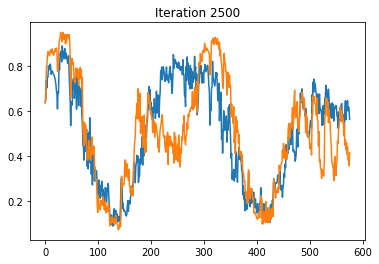

Iterations: 2508
Iterations: 2530
Iterations: 2552
Iterations: 2574
Iterations: 2596
Iterations: 2618
Iterations: 2640
Iterations: 2662
Iterations: 2684
Iterations: 2706
Iterations: 2728
Iterations: 2750
Iterations: 2772
Iterations: 2794
Iterations: 2816
Iterations: 2838
Iterations: 2860
Iterations: 2882
Iterations: 2904
Iterations: 2926
Iterations: 2948
Iterations: 2970
Iterations: 2992
iterations  3000
Average P(real)= 0.3424262
Average P(gen)= 0.33309305
Discrim loss: 305.8291


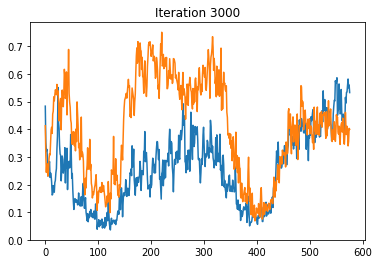

Iterations: 3014
Iterations: 3036
Iterations: 3058
Iterations: 3080
Iterations: 3102
Iterations: 3124
Iterations: 3146
Iterations: 3168
Iterations: 3190
Iterations: 3212
Iterations: 3234
Iterations: 3256
Iterations: 3278
Iterations: 3300
Iterations: 3322
Iterations: 3344
Iterations: 3366
Iterations: 3388
Iterations: 3410
Iterations: 3432
Iterations: 3454
Iterations: 3476
Iterations: 3498
iterations  3500
Average P(real)= 0.34516755
Average P(gen)= 0.3391932
Discrim loss: 195.76758


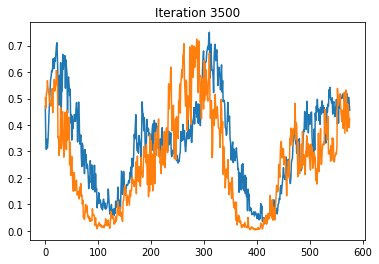

Iterations: 3520
Iterations: 3542
Iterations: 3564
Iterations: 3586
Iterations: 3608
Iterations: 3630
Iterations: 3652
Iterations: 3674
Iterations: 3696
Iterations: 3718
Iterations: 3740
Iterations: 3762
Iterations: 3784
Iterations: 3806
Iterations: 3828
Iterations: 3850
Iterations: 3872
Iterations: 3894
Iterations: 3916
Iterations: 3938
Iterations: 3960
Iterations: 3982
iterations  4000
Average P(real)= 0.34787726
Average P(gen)= 0.33641356
Discrim loss: 375.64258


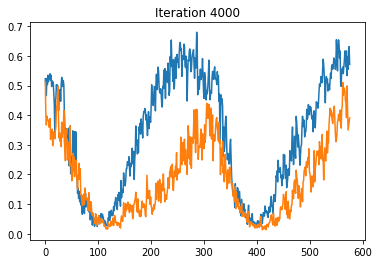

Iterations: 4004
Iterations: 4026
Iterations: 4048
Iterations: 4070
Iterations: 4092
Iterations: 4114
Iterations: 4136
Iterations: 4158
Iterations: 4180
Iterations: 4202
Iterations: 4224
Iterations: 4246
Iterations: 4268
Iterations: 4290
Iterations: 4312
Iterations: 4334
Iterations: 4356
Iterations: 4378
Iterations: 4400
Iterations: 4422
Iterations: 4444
Iterations: 4466
Iterations: 4488
iterations  4500
Average P(real)= 0.3509479
Average P(gen)= 0.34239304
Discrim loss: 280.3252


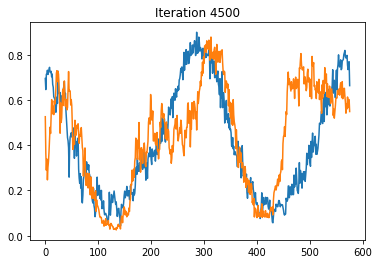

Iterations: 4510
Iterations: 4532
Iterations: 4554
Iterations: 4576
Iterations: 4598
Iterations: 4620
Iterations: 4642
Iterations: 4664
Iterations: 4686
Iterations: 4708
Iterations: 4730
Iterations: 4752
Iterations: 4774
Iterations: 4796
Iterations: 4818
Iterations: 4840
Iterations: 4862
Iterations: 4884
Iterations: 4906
Iterations: 4928
Iterations: 4950
Iterations: 4972
Iterations: 4994
iterations  5000
Average P(real)= 0.3496126
Average P(gen)= 0.3385716
Discrim loss: 361.79102


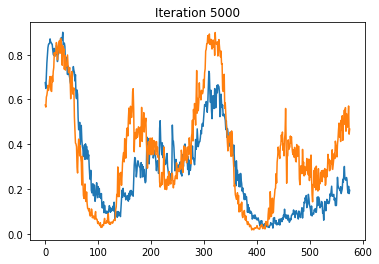

Iterations: 5016
Iterations: 5038
Iterations: 5060
Iterations: 5082
Iterations: 5104
Iterations: 5126
Iterations: 5148
Iterations: 5170
Iterations: 5192
Iterations: 5214
Iterations: 5236
Iterations: 5258
Iterations: 5280
Iterations: 5302
Iterations: 5324
Iterations: 5346
Iterations: 5368
Iterations: 5390
Iterations: 5412
Iterations: 5434
Iterations: 5456
Iterations: 5478
Iterations: 5500
iterations  5500
Average P(real)= 0.35297114
Average P(gen)= 0.3411465
Discrim loss: 387.46973


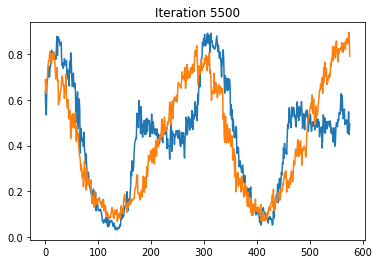

Iterations: 5522
Iterations: 5544
Iterations: 5566
Iterations: 5588
Iterations: 5610
Iterations: 5632
Iterations: 5654
Iterations: 5676
Iterations: 5698
Iterations: 5720
Iterations: 5742
Iterations: 5764
Iterations: 5786
Iterations: 5808
Iterations: 5830
Iterations: 5852
Iterations: 5874
Iterations: 5896
Iterations: 5918
Iterations: 5940
Iterations: 5962
Iterations: 5984
iterations  6000
Average P(real)= 0.35258773
Average P(gen)= 0.33724242
Discrim loss: 502.83496


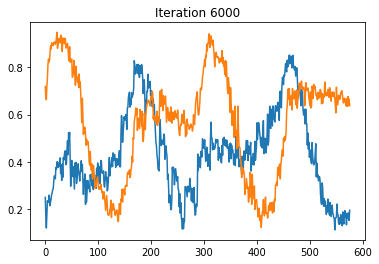

Iterations: 6006
Iterations: 6028
Iterations: 6050
Iterations: 6072
Iterations: 6094
Iterations: 6116
Iterations: 6138
Iterations: 6160
Iterations: 6182
Iterations: 6204
Iterations: 6226
Iterations: 6248
Iterations: 6270
Iterations: 6292
Iterations: 6314
Iterations: 6336
Iterations: 6358
Iterations: 6380
Iterations: 6402
Iterations: 6424
Iterations: 6446
Iterations: 6468
Iterations: 6490
iterations  6500
Average P(real)= 0.3536399
Average P(gen)= 0.33139712
Discrim loss: 728.85156


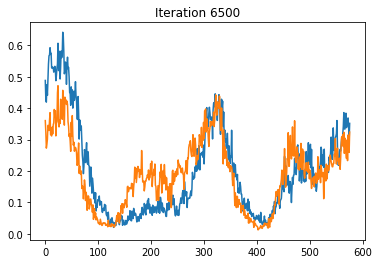

Iterations: 6512
Iterations: 6534
Iterations: 6556
Iterations: 6578
Iterations: 6600
Iterations: 6622
Iterations: 6644
Iterations: 6666
Iterations: 6688
Iterations: 6710
Iterations: 6732
Iterations: 6754
Iterations: 6776
Iterations: 6798
Iterations: 6820
Iterations: 6842
Iterations: 6864
Iterations: 6886
Iterations: 6908
Iterations: 6930
Iterations: 6952
Iterations: 6974
Iterations: 6996
iterations  7000
Average P(real)= 0.36238104
Average P(gen)= 0.32895127
Discrim loss: 1095.4268


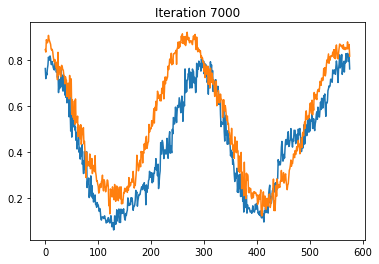

Iterations: 7018
Iterations: 7040
Iterations: 7062
Iterations: 7084
Iterations: 7106
Iterations: 7128
Iterations: 7150
Iterations: 7172
Iterations: 7194
Iterations: 7216
Iterations: 7238
Iterations: 7260
Iterations: 7282
Iterations: 7304
Iterations: 7326
Iterations: 7348
Iterations: 7370
Iterations: 7392
Iterations: 7414
Iterations: 7436
Iterations: 7458
Iterations: 7480
iterations  7500
Average P(real)= 0.35985768
Average P(gen)= 0.32883164
Discrim loss: 1016.66113


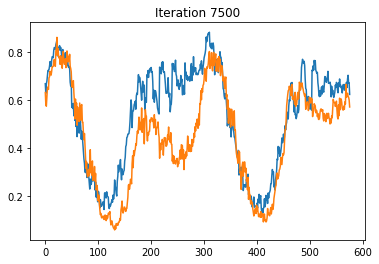

Iterations: 7502
Iterations: 7524
Iterations: 7546
Iterations: 7568
Iterations: 7590
Iterations: 7612
Iterations: 7634
Iterations: 7656
Iterations: 7678
Iterations: 7700


In [ ]:
### train.py  file

# Training parameters
#maxiters = 1750
maxiters = 10000
learning_rate = 0.0002

# Folder to save generated images to
RUN = 5
folder_name = '/Volumes/Eluteng/cs159/run_load' + str(RUN) + '/'
#folder_name = 'generative_models/runs/run' + str(RUN) + '/'
if os.path.isdir(folder_name):
    raise ValueError(f'Folder for RUN={RUN} already exists')

!mkdir $folder_name

# Start tensorflow session
#sess.close()
sess = tf.InteractiveSession()
# Start saver to save model during training
saver = tf.train.Saver(max_to_keep=10)

discrim_vars = filter(lambda x: x.name.startswith('discrim'), tf.trainable_variables())
gen_vars = filter(lambda x: x.name.startswith('gen'), tf.trainable_variables())
discrim_vars = [i for i in discrim_vars]
gen_vars = [i for i in gen_vars]

train_op_discrim = (tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(-d_cost_tf, var_list=discrim_vars))
train_op_gen = (tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(g_cost_tf, var_list=gen_vars))

# Z_tf_sample, Y_tf_sample, image_tf_sample: placeholders
Z_tf_sample, Y_tf_sample, image_tf_sample = gan.samples_generator(batch_size=visualize_dim)
tf.initialize_all_variables().run()

iterations = 0
k = 4 #control the balance of training D and G

gen_loss_all=[]
P_real=[]
P_fake=[]
P_distri=[]
discrim_loss=[]


# Begin training
while iterations < maxiters:
    print("Iterations: " + str(iterations))
    
    # Shuffle training data set
    index = np.arange(trX.shape[0])
    np.random.shuffle(index)
    trX = trX[index]
    trY = trY[index]
    trY2 = enc.transform(trY)

    for start, end in zip(
            range(0, trX.shape[0], gan.batch_size),
            range(gan.batch_size, trX.shape[0], gan.batch_size)
            ):

        Xs = trX[start:end].reshape([-1, 24, 24, 1])
        Ys = trY2[start:end]

        #use Gaussian distribution data to generate adversarial samples
        Zs = np.random.normal(mu, sigma, size=[gan.batch_size, gan.dim_z]).astype(np.float32)

        #for each iteration, generate g and d respectively, k=2
        if np.mod( iterations, k) == 0:
            _, gen_loss_val = sess.run(
                    [train_op_gen, g_cost_tf],
                    feed_dict={
                        Z_tf:Zs,
                        Y_tf:Ys,
                        image_tf: Xs
                        })
            discrim_loss_val, p_real_val, p_gen_val = sess.run([d_cost_tf,p_real,p_gen], feed_dict={Z_tf:Zs, Y_tf:Ys, image_tf:Xs})

        else:
            _, discrim_loss_val = sess.run(
                    [train_op_discrim, d_cost_tf],
                    feed_dict={
                        Z_tf:Zs,
                        Y_tf:Ys,
                        image_tf:Xs
                        })

            gen_loss_val, p_real_val, p_gen_val = sess.run([g_cost_tf, p_real, p_gen],
                                                       feed_dict={Z_tf: Zs, image_tf: Xs,  Y_tf: Ys})
        P_real.append(p_real_val.mean())
        P_fake.append(p_gen_val.mean())

        discrim_loss.append(discrim_loss_val)

        if np.mod(iterations, 500) == 0:
            print("iterations ", iterations)
            print("Average P(real)=", p_real_val.mean())
            print("Average P(gen)=", p_gen_val.mean())
            print("Discrim loss:", discrim_loss_val)

            Z_np_sample = np.random.normal(mu, sigma, size=[gan.batch_size, gan.dim_z]).astype(np.float32)
            Y_np_sample = enc.transform(np.random.randint(num_categories, size=[visualize_dim, 1]))
                            
            generated_samples = sess.run(
                image_tf_sample,
                feed_dict={Z_tf_sample: Z_np_sample, Y_tf_sample: Y_np_sample})
            generated_samples = generated_samples.reshape([-1,576])
            generated_samples = generated_samples * gan.max_value
            csvfile = folder_name + f'samples_{iterations}.csv'
            with open(csvfile, 'w') as f:
                writer = csv.writer(f)
                writer.writerows(generated_samples)
                
            plt.figure()
            for sample in generated_samples[:2, :]:
                plt.plot(sample)
            plt.title(f'Iteration {iterations}')
            plt.show()

        iterations += 1

Y_np_sample = enc.transform(np.random.randint(num_categories, size=[visualize_dim, 1]))
Z_np_sample = np.random.normal(mu, sigma, size=[batch_size, dim_z]).astype(np.float32)
generated_samples = sess.run(
    image_tf_sample,
    feed_dict={Z_tf_sample: Z_np_sample, Y_tf_sample: Y_np_sample})
generated_samples = generated_samples.reshape([-1,576])
generated_samples = generated_samples * gan.max_value
csvfile = folder_name + 'sample1.csv'
with open(csvfile, 'w')  as f:
    writer = csv.writer(f)
    writer.writerows(generated_samples)
    
# Print total number of iterations
print(f'Total number of iterations: {iterations}')

#plot the loss and P_real as well as P_fake
# print("P_real",P_real)
# print("P_fake",P_fake)

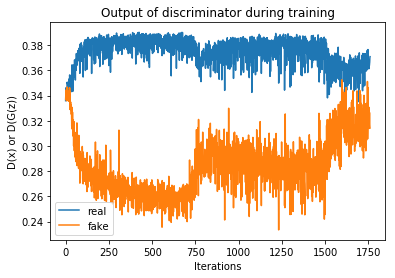

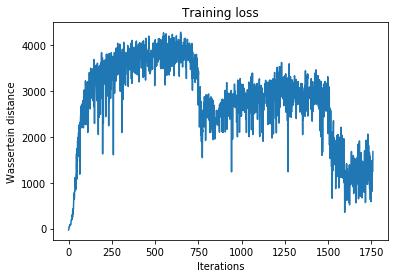

In [40]:
# Plot propobility curves
plt.plot(P_real,label="real")
plt.plot(P_fake,label="fake")
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('D(x) or D(G(z))')
plt.title('Output of discriminator during training')
#plt.savefig('generative_models/figures/D_solar_4600')
plt.show()

plt.plot(discrim_loss)
plt.xlabel('Iterations')
plt.ylabel('Wassertein distance')
plt.title('Training loss')
#plt.savefig('generative_models/figures/loss_solar_4600')
plt.show()

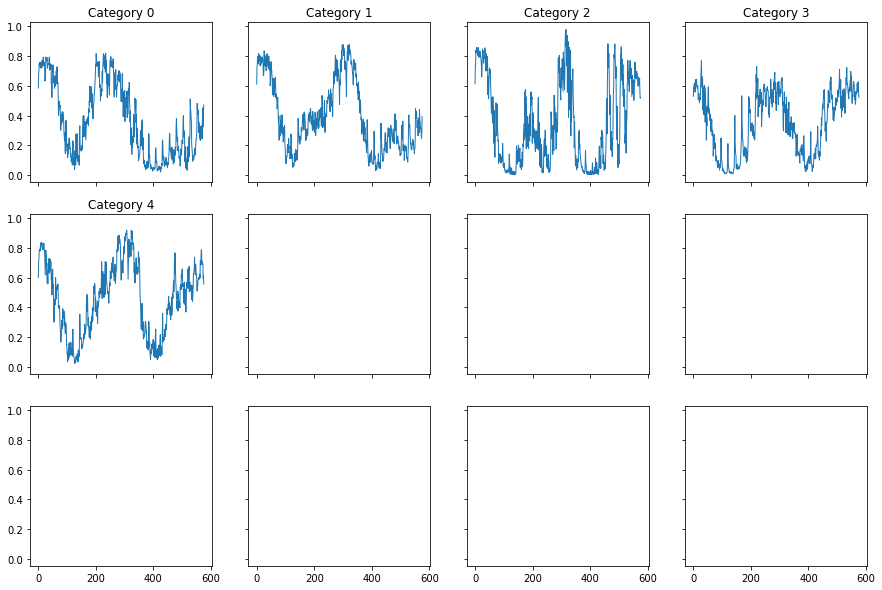

In [41]:
# Generate examples of each category
fig, axes = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(15, 10))
axes = axes.flatten()

for i in range(num_categories):
    ax = axes[i]
    done = False
    while not done:
        y_np_sample = np.random.randint(num_categories, size=(visualize_dim, 1))
        Y_np_sample = enc.transform(y_np_sample)
        Z_np_sample = np.random.normal(mu, sigma, size=[batch_size, dim_z]).astype(np.float32)
        generated_samples = sess.run(
                image_tf_sample,
                feed_dict={Z_tf_sample: Z_np_sample,  Y_tf_sample: Y_np_sample})
        generated_samples = generated_samples.reshape([-1,576])
        generated_samples = generated_samples * gan.max_value

        n_subplot = 0
        for sample_id, sample in enumerate(generated_samples):
            if y_np_sample[sample_id][0] == i:
                ax.plot(sample, linewidth=1.)
                done = True
                if n_subplot == 0:
                    break
                else:
                    n_subplot += 1
        ax.title.set_text(f'Category {y_np_sample[sample_id][0]}')

# plt.savefig('../VER_GenerativeModelling_RLAllocation/generative_models/figures'
#             '/solar_categories_examples.png',
#             tight_layout=True)
plt.show()

In [142]:
def get_production_per_time_step(X, num_points):
    '''
    Return total power produced during num_points time_steps of x.
    E.g.: if x has a resolution of 5min, setting num_points=12 returns
    the amount of power produced during every hour in x.
    '''
    # Clip x to keep a multiple of num_points points
    max_idx = X.shape[1] - X.shape[1] % num_points
    temp = X[:, :max_idx]
    
    # Sum num_consecutive points
    temp = temp.reshape((-1, num_points))
    sums = np.mean(temp, axis=1).flatten()
    
    # Print info
    print(f'Size of original time series: {x.size}')    
    print(f'Size of new time series: {sums.size}')
    
    return sums

def generate_solar_data(num_days=2, labels=None):
    ''' 
    Generate data for num_days days as a single time-series.
    This is done by generating 2-day long time-series, and concatenating them.
    '''
    batch_size = 32
    num_categories = 12
    num_samples = int(num_days / 2) # number of 2-day samples to generate
    
    # Use random labels if none are provided
    if labels is None:
        labels = np.random.randint(num_categories, size=(32 * num_samples, 1))

    labels_one_hot = enc.transform(labels)
    
    # Generate num_days / 2 samples
    all_samples = np.empty((0, 576))
    while all_samples.shape[0] < num_samples:
        
        # Generate a batch of 32 samples
        Z_np_sample = np.random.normal(mu, sigma, size=[batch_size, dim_z]).astype(np.float32)
        Y_np_sample = labels_one_hot[all_samples.shape[0]: all_samples.shape[0] + batch_size, :]
        generated_samples = sess.run(
                image_tf_sample,
                feed_dict={Z_tf_sample: Z_np_sample,  Y_tf_sample: Y_np_sample})
        generated_samples = generated_samples.reshape([-1,576])
        generated_samples = generated_samples * gan.max_value
        
        # Stack the new batch of samples
        subset_index = np.min([32, num_samples - all_samples.shape[0]]).astype(np.int)
        subset = generated_samples[:subset_index, :]
        all_samples = np.vstack((all_samples, subset))
    
        # Concatenate to return a single time-series
        time_series = all_samples.flatten()
    
    return time_series

## GENERATE SOLAR DATA FOR RL PROBLEM

In [42]:
def gen_dataset(n_samples):
    mu, sigma = 0., 0.1
    batch_size = 32
    dim_z = 100
    max_value = 74
    
    X = np.empty((0, 576))
    while X.shape[0] < n_samples:
        
        # Generate a batch of 32 samples
        Z_np_sample = np.random.normal(mu, sigma, size=[batch_size, dim_z]).astype(np.float32)
        Y_np_sample = enc.transform(np.random.randint(num_categories, size=(32, 1)))
        generated_samples = sess.run(
                image_tf_sample,
                feed_dict={Z_tf_sample: Z_np_sample,  Y_tf_sample: Y_np_sample})
        generated_samples = generated_samples.reshape([-1,576])
        generated_samples = generated_samples * max_value
        
        # Concatenate new generated data
        X = np.vstack((X, generated_samples))

    return X

def reduce_resolution(X, num_points):
    '''
    Return total power produced during num_points time_steps of x.
    E.g.: if x has a resolution of 5min, setting num_points=12 returns
    the amount of power produced during every hour in x.
    '''
    # Clip x to keep a multiple of num_points points
    max_idx = X.shape[1] - X.shape[1] % num_points
    temp = X[:, :max_idx]
    
    # Sum num_consecutive points
    temp = temp.reshape((-1, temp.shape[0], num_points))
    sums = np.mean(temp, axis=2)
    
    sums = sums.reshape((X.shape[0], -1))
    
    # Print info
    print(f'Shape of original time series: {X.shape}')    
    print(f'Shape of new time series: {sums.shape}')
    
    return sums

for i in range(1):
    new_dataset = gen_dataset(10000)
    print(new_dataset.shape)
    new_dataset_hourly = reduce_resolution(new_dataset, 12)

    #csvfile_solar_random_labeled = f'/Volumes/Eluteng/cs159/gen_solar_data/solar_random_labels_{i}.csv'
    #print('Saving file: ', csvfile_solar_random_labeled)
    #np.savetxt(csvfile_solar_random_labeled, new_dataset_hourly, delimiter=',')

(10016, 576)
Shape of original time series: (10016, 576)
Shape of new time series: (10016, 48)


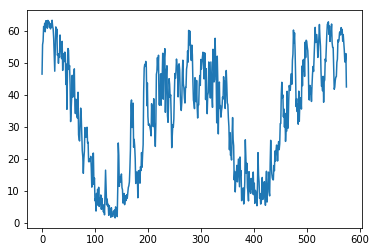

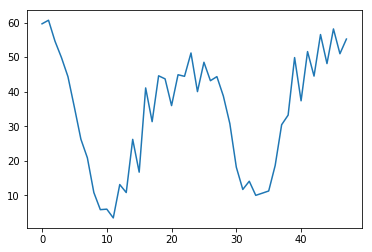

In [45]:
# Plot newly generated data
plt.figure()
plt.plot(new_dataset[0, :])

# Plot hourly data
plt.figure()
plt.plot(new_dataset_hourly[0, :])